# COMP47700 Speech and Audio PL4: Audio Degradations

## Learning Outcomes
* Describe the signal characteristics of speech and audio signals using
appropriate terminology
  * Understand the importance of simulating degradations.
* Apply signal processing algorithms to speech and audio signals
  * Gain knowledge of clipping distortion and simulate clipping from scratch using Python.
  * Gain knowledge of convolution and impulse response, covering both theory and practical application through Python coding.
  * Understand background noise and SNR concepts.
* Create programmes to conduct experiments on speech and audio samples building on third software libraries
  * Simulate a voice call by sequentially applying degradations and reflecting on the order of degradation.

## Module Topics
Advanced topics Speech and Audio Quality

*   Speech and Audio Quality
*   Objective models of intelligibility and quality

## Why is it important?
* Objective Quality Evaluation:

  * Assessing speech quality in diverse conditions (background noise, packet loss, distortion).
  * Generating artificial degradations facilitates testing quality metrics in realistic scenarios.

* Speech Enhancement and Separation Algorithms:
  * Artificial degradations enable testing these algorithms in diverse real-world conditions.

* Deep Learning:
  * Creating large training datasets with various degradations reduces bias and enhances model generalization.
  * Data augmentation, involving modified speech signal copies, improves performance, especially with limited datasets.

## Structure of this tutorial
This practical tutorial contains different sections:
* **Live coding:** Basic theory, demos and coding examples presented by the lecturer on site (unmarked)
* **Student activity:** Familiarisation and coding exercises to be completed by the students and followed by a short discussion on site (unmarked). These activities introduce key concepts and skills necessary to complete the assignments.
* **Assignment:** Two (2) take home problem/coding questions to be completed by the students by (see Unit 2 brightspace). Assignment questions represent fifteen (15) mark points.


>[COMP47700 Speech and Audio PL4: Audio Degradations](#scrollTo=G1u99MLkem-u)

>>[Learning Outcomes](#scrollTo=QlPWpMNxPt3R)

>>[Module Topics](#scrollTo=QlPWpMNxPt3R)

>>[Why is it important?](#scrollTo=QlPWpMNxPt3R)

>>[Structure of this tutorial](#scrollTo=QlPWpMNxPt3R)

>>[Setup](#scrollTo=bCopdUx1GOtb)

>>>[Live coding: Uploading files from local system](#scrollTo=_1iyH7VZYhlw)

>[Live Coding: Clipping](#scrollTo=DWBZH2Onbe-b)

>>[Example](#scrollTo=PHM7-mYRffAP)

>>[Clipped Signal Math Representation](#scrollTo=h5H_fc8NA5YP)

>>[Analog vs. Digital Clipping](#scrollTo=vOAwug1vz8D3)

>>[Coding Part](#scrollTo=VrQFyHf2Zmvp)

>[Live Coding: Room Reverberation](#scrollTo=fBenHw4cfr2v)

>>[Problem Definition](#scrollTo=hKpcwNomdpuR)

>>[Solution](#scrollTo=hKpcwNomdpuR)

>>[Coding Part](#scrollTo=M-fsVBkzMNz8)

>[Live Coding: Background Noise](#scrollTo=16uZOQtEgYZ3)

>>[Problem Definition](#scrollTo=Mu2qHWd6ueAK)

>>[Coding Part](#scrollTo=xW_WeSCocm8L)

>[Student Activity: Voice Call Simulation](#scrollTo=tZxZVOomFSix)

>>[Exercise](#scrollTo=n3nT-Gy-gpXx)

>[Assignment](#scrollTo=WIF0uD_meJ8k)

>>>[Part 1 [5pt]](#scrollTo=7xTplpQedIes)

>>>[Part 2 [10pt]](#scrollTo=5mHd-3qwbZAR)

>[Additional Material](#scrollTo=FzqKey1thTId)



## Setup
Import libraries

In [ ]:
import librosa
from librosa import display
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import os
import math
import gdown
from IPython.display import Image

### **Live coding:** Uploading files from local system
We will upload and extract the content from the zip file provided with the assigment (Brightspace -> Assignment Questions PL4).
1. Import the library `files` from Google Colab
2. From your local system, select the .zip file provided for PL4 (`PL4_files.zip`)
3. Using the `zipfile` library, extract the files to your Google Colab environment (`./PL4_files/`).

In [ ]:
from google.colab import files
zipname = 'PL4_files.zip'
# If the command below fails, upload the file manually and run the next cell
#uploaded = files.upload()

In [ ]:
import zipfile
# Extract the zip file
with zipfile.ZipFile(zipname, 'r') as zip_ref:
  zip_ref.extractall()  # Extract all files to the current directory

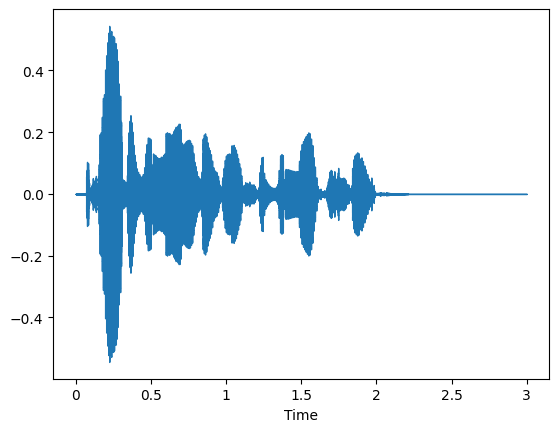

In [ ]:
# Loading the clean speech file to a numpy array - x[n].
## We downsample the speech file from 48 kHz (original sampling rate) to 16 kHz
## N.B The command librosa.load automatically represents audio in float 32 bit

# Frequency sampling
sampling_rate = 16000

# Filename
clean_speech_filename = 'R_01_CLIP_MK.wav'

# Load audio file
x, _ = librosa.load(clean_speech_filename, mono=True, sr=sampling_rate)

# Extract 3 seconds from 1s to 4s
x = x[sampling_rate:sampling_rate*4]

#Plot waveform
display.waveshow(x, sr=sampling_rate)

# Player
ipd.Audio(x, rate=sampling_rate, normalize=False)


# **Live Coding**: Clipping
Clipping occurs when the audio signal's amplitude is greater than a maximum allowed limit. Amplitudes beyond this limit are truncated to the maximum allowed limit which results in audio distortion.
The limit takes different meaning depending on whether we are in the analog domain or in the digital domain.




## Example
In this example we show how to clip a sine wave at 1 Hz.

A discrete-time sine wave can be written as:

$s[n] = A\sin(2\pi\frac{f}{fs}n + \theta$) where:


*   $A$ is the wave amplitude
*   $f$ is the frequency in Hz
*   $fs$ is the frequency sampling in Hz
*   $2πf$ is the angular frequency in radians
*   $n$ is a discrete time instant
*   $\theta$ is the phase

Text(0, 0.5, 'Amplitude')

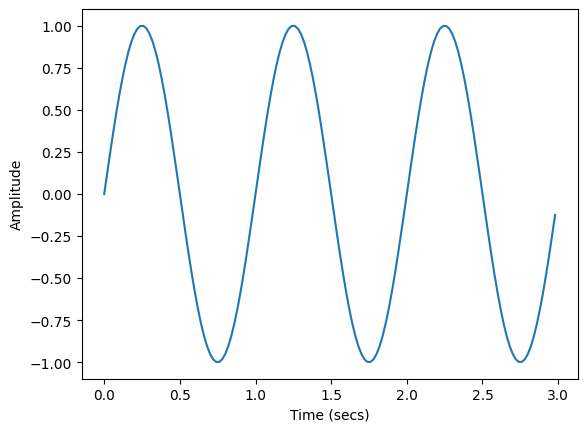

In [ ]:
# Sinusoid amplitude
A = 1

# Sine wave frequency (Hz)
f = 1

# Sampling rate (50 Hz) must be greater than 2*f (Nyquist theorem)
fs = 50

# Phase (radians)
theta = 0

# Angular frequency (radians)
w = 2*np.pi*f

# Duration of the signal (secs) - The signal needs to have a finite duration!
T = 3
timestamps = np.arange(0, T, 1/fs) # This defines all the discrete time instants "n" in the mathematical expression above

# Generate sine wave
x_sin = A*np.sin(w*timestamps + theta)

# Plot sinusoid (keep in mind that plt.plot does an interpolatation of the discrete points)
plt.plot(timestamps, x_sin)
plt.xlabel('Time (secs)')
plt.ylabel('Amplitude')

To clip the sine wave we define a threshold level above which the signal will be truncated. For example, if the threshold level is $0.8$ we clip all the values above $0.8$ and below $-0.8$ to the threshold level.

Maximum value: 0.8
Minimum value: -0.8


Text(0, 0.5, 'Amplitude')

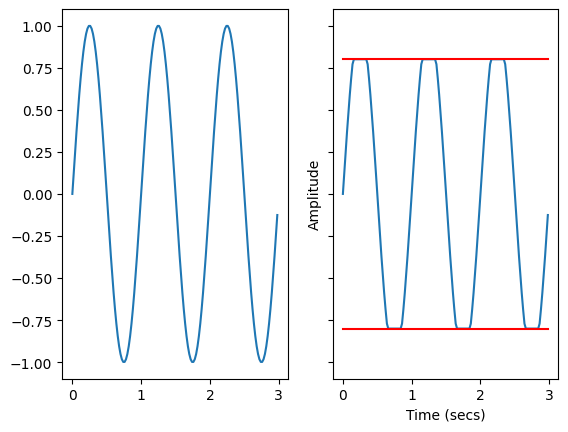

In [ ]:
# Threshold level
threshold_level = 0.8

# Clip values
x_sin_clipped = x_sin.copy()
x_sin_clipped[x_sin_clipped>threshold_level] = threshold_level
x_sin_clipped[x_sin_clipped<-threshold_level] = -threshold_level

# Check that the maximum value is lower than 0.8 and the minimum value is greater than -0.8
print(f'Maximum value: {np.round(x_sin_clipped.max(), 2)}')
assert x_sin_clipped.max() <= threshold_level
print(f'Minimum value: {np.round(x_sin_clipped.min(), 2)}')
assert x_sin_clipped.min() >= -threshold_level

# Visualize clipped sine wave and the threshold level
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
# Plot original signal
axs[0].plot(timestamps, x_sin)
# Plot clipped signal
axs[1].plot(timestamps, x_sin_clipped)
# Plot threshold
axs[1].plot(timestamps, [threshold_level]*timestamps.shape[0], color='red')
axs[1].plot(timestamps, [-threshold_level]*timestamps.shape[0], color='red')
axs[1].set_xlabel('Time (secs)')
axs[1].set_ylabel('Amplitude')


## **Clipped Signal Math Representation**
$
  y[n]=
\begin{cases}
    x[n],                   & |x[n]| < α  \\
    \alpha*sgn(x[n]),       & |x[n]| ≥ α
\end{cases}
$

* $x[n]$ - Clean speech signal
* $y[n]$ - Clipped speech signal
* $\alpha$ - Maximum allowed representation value
* $sgn(x[n])$ - It returns the sign of $x[n]$ ($\pm$)

## **Analog vs. Digital Clipping**
*   Clipping in the digital domain occurs when we push the signal beyond the possible representation values. Digital signals are represented by a finite number of possible values that can be used to represent the amplitude. For example, in a $16$ bit system, $2^{16} = 65,536$ values are allowed in the range [$-32,768,32,767$]. Let's take an amplitude value that is represented by the number $30,000$ and double it to $60,000$. In this case the value will be truncated to $32,768$ which is the largest value that can be represented in our $16$ bit digital system. Digital domain produces what is called **hard clipping** i.e. the values above the limit are truncated exactly to the threshold level. The example with the sine wave above is hard clipping.

*   In the analog domain, amplifiers can amplify the amplitude up to a certain limit. If the input level is too high, they will be truncated to the limit of the amplifier. For example, when we record a live concert with our smartphone, the microphone picks up a signal that is too loud for the microphone amplifier which truncates the signal to its maximum capability. Analog domain produces **soft clipping**, where the values greater than the threshold still follow the original waveshape but at reduced gain. It is less unpleasant than hard clipping. It is used for artistic purposes e.g. electric guitar overdrive is based on this principle.

## Coding Part ##

When clipping a real-world audio signal we cannot simply guess a threshold level since audio signals are represented by thousands of samples. An ideal approach is to choose the percentage of samples that we want to clip.

1.   Given a clean speech signal, apply clipping to $10\%$ of the audio samples.

2.   Evaluate the clipped signal (listening and plotting the waveform) by increasing the number of affected samples (e.g. $40\%$).

To clip a percentage of samples in the waveform we use the percentile since we know that if an amplitude value $x[n]$ is at the $k$-th percentile, then $x[n]$ is greater than $k\%$ of the values.
To calculate percentile in python we use the numpy function np.percentile https://numpy.org/doc/stable/reference/generated/numpy.percentile.html

In [ ]:
# ***********************************************************************************************
# 1.   Given a clean speech signal, apply clipping to $10\%$ of the audio samples.

# Calculate percentile values.
clip_factor = 10
def get_percentile(clip_factor):
  lower_percentile = clip_factor/2
  higher_percentile = 100 - lower_percentile
  percentile_values = np.percentile(x, [lower_percentile, higher_percentile])
  return lower_percentile, higher_percentile, percentile_values

lower_percentile, higher_percentile, percentile_values = get_percentile(clip_factor)
print(f'{lower_percentile}-th percentile: {percentile_values[0]:.5f}')
print(f'{higher_percentile}-th percentile: {percentile_values[1]:.5f}')

5.0-th percentile: -0.06447
95.0-th percentile: 0.07268


We now need to truncate the signal to the percentile values found above.



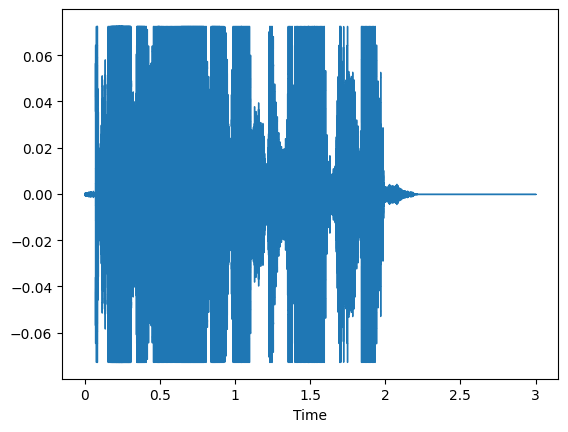

In [ ]:
# Obtain clipped signal
def clip_signal(x, percentile_values):
  y = x.copy()
  y[y>percentile_values[1]], y[y<percentile_values[0]] = percentile_values[1], percentile_values[0]
  return y

y = clip_signal(x, percentile_values)

# Plot waveform
display.waveshow(y, sr=sampling_rate)

# Player
ipd.Audio(y, rate=sampling_rate, normalize=False)


The degraded signal is quieter than the original signal since clipping truncates higher peaks. We want that the clean and the degraded signal to have the same loudness since in real-world recordings a degradation does not imply quieter or louder volume.

To match the volume between the two signals several normalization techniques exist:


1.   Peak Normalization
  - $x_{norm}[n]=\frac{x[n]}{\max_\limits{\forall{n}}|x[n]|}$
  - Too sensitive when introducing distortion in the signal
2.   Loudness Normalization
  - Based on normalizing a signal by transforming the average loudness to a target loudness
  - Less sensitive to distortions
  - A simple way is to measure the average power of $x$ using root mean square (RMS) and scaling $y$ so that $RMS_y=RMS_x$
  - More sophisticated techniques are based on human perception (e.g. EBU R 128)

We will use RMS normalization. The RMS of a signal is used to measure the average power $RMS_x = \sqrt{\frac{1}{N}(x{^2_1} + x{^2_2} + ... + x{^2_N})}$.

We want to find a scaling factor $\gamma$ such that $\gamma y[n] \implies RMS_x=RMS_y$.

The scaling factor can be derived from the RMS formula and is equal to $\gamma=\sqrt{\frac{N*RMS_x^2}{\sum_\limits{i=1}^{N}y_i^2}}$


In [ ]:
# Find RMSx (i.e. the target RMS)
rms_x = np.sqrt(np.mean(x**2))

#  Find scaling factor gamma
N = x.shape[0]
gamma = np.sqrt((N*rms_x**2)/(np.sum(y**2)))
print(f'Scaling factor :{gamma:.4f}')

# Normalize y
y_norm = gamma*y

# Check that RMSx=RMSynorm
print(f'RMSx = {rms_x:.3f}')
print(f'RMSy = {np.sqrt(np.mean(y**2)):.3f}')
print(f'RMSynorm = {np.sqrt(np.mean(y_norm**2)):.3f}')

# Play both clean and degraded signal
ipd.display(ipd.Audio(x, rate=sampling_rate, normalize=False))
ipd.display(ipd.Audio(y, rate=sampling_rate, normalize=False))
ipd.display(ipd.Audio(y_norm, rate=sampling_rate, normalize=False))

Scaling factor :1.6012
RMSx = 0.048
RMSy = 0.030
RMSynorm = 0.048


Can you hear clipping?
Let's increase the clip factor to $40\%$ of the samples.

20.0-th percentile: -0.01802
80.0-th percentile: 0.00994
Scaling factor :4.7395
RMSx = 0.048
RMSy = 0.010
RMSynorm = 0.048


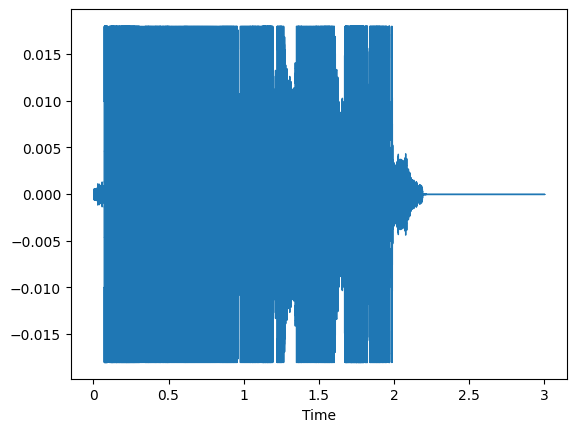

In [ ]:
# ***********************************************************************************************
# 2.   Evaluate the clipped signal (listening and plotting the waveform) by increasing the number of affected samples (e.g. 40\%).

clip_factor = 40

# Get percentile values
lower_percentile, higher_percentile, percentile_values = get_percentile(clip_factor)
print(f'{lower_percentile}-th percentile: {percentile_values[0]:.5f}')
print(f'{higher_percentile}-th percentile: {percentile_values[1]:.5f}')

# Clipping
y = clip_signal(x, percentile_values)

# Plot waveform
librosa.display.waveshow(y, sr=sampling_rate)

# Normalize audio
gamma = np.sqrt((N*rms_x**2)/(np.sum(y**2)))
print(f'Scaling factor :{gamma:.4f}')
y_norm = gamma * y

# Check that RMSx=RMSynorm
print(f'RMSx = {rms_x:.3f}')
print(f'RMSy = {np.sqrt(np.mean(y**2)):.3f}')
print(f'RMSynorm = {np.sqrt(np.mean(y_norm**2)):.3f}')

# Player
ipd.display(ipd.Audio(x, rate=sampling_rate, normalize=False))
ipd.display(ipd.Audio(y, rate=sampling_rate, normalize=False))
ipd.display(ipd.Audio(y_norm, rate=sampling_rate, normalize=False))

Clip distortion is audible when using a higher clip factor. The waveform plot shows that more samples were clamped which causes the distortion to be more noticeable than in the previous example.

In this example, we have seen how the scale factor was around 5 and that without normalization the clipped signal was very quiet.

# **Live Coding**: Room Reverberation

Did you notice that your voice does not sound the same in every room? This is due to the different natural reverberation created by the environment. Sound is affected by the shape of the room and by wall properties.

## Problem Definition
In this exercise, we will see how to simulate a voice recorded in a real-world environment (e.g. art gallery).
To do that we use the convolution operation between the speech clean signal and the impulse response captured in the environment.

Imagine a room as a black box system $H$ that takes an input audio signal that is clean without reverb (e.g. your voice) $x[n]$ and transforms it to $y[n]$. The signal $y[n]$ is still your voice but it has reverb, which depends on the particular room $H$.
What we are trying to get is a representation of $H$ such that every time we want to simulate a voice in this physical environment, we don't need to be physically present there.
This representation is called the impulse response. More specifically, in this case, we call it the room impulse response (RIR).

## Solution
First, we need to be in the room and generate an impulse (e.g. balloon popping) and we record the generated sound. Why an impulsive sound? An impulse covers the frequency spectrum, in this way we know how the room reacts at every frequency.
Once we have the response of the room to our impulse, we can use it to simulate how any other input signal would sound in the same room.

Once we have the clean signal $x[n]$ and the RIR $H$ we need to find a mathematical operation that will describe how $x[n]$ is affected by $H$. This operation is called convolution. Why convolution and not multiplication or a sum? A math proof exists, but a simple intuition lies behind the fact that discrete-time signals can be seen as a sum of several delayed impulses.

In this tutorial, we use RIRs from the EchoThief database http://www.echothief.com/downloads/






## Coding Part ##
1. Plot a RIR waveform in both time and time-frequency domains
2. Calculate the convolution between the clean speech signal and the RIR
3. Plot waveform of original speech and reverberated speech side by side

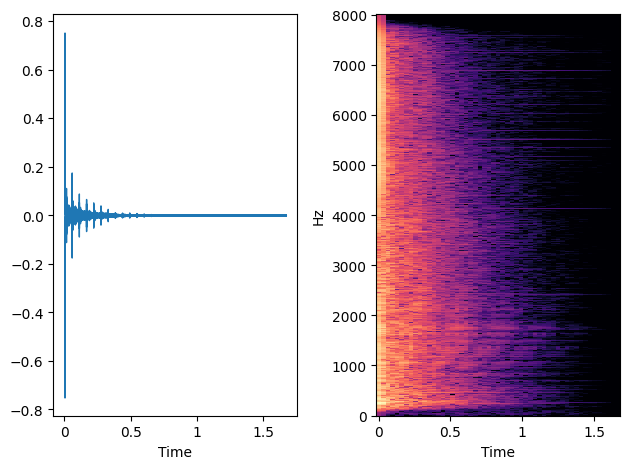

In [ ]:
# ***********************************************************************************************
# 1. Plot a RIR waveform in both time and time-frequency domains

# First, load the room impulse response and visualise both in time and time-frequency domains
rir_filename = 'Space4ArtGallery.wav'

# Load impulse response, make sure that both sampling rate and number of channels are the same of the clean signal
rir, _ = librosa.load(rir_filename, mono=True, sr=sampling_rate)

# Plot waveform and spectrogram
fig, axs = plt.subplots(nrows=1, ncols=2)
librosa.display.waveshow(rir, sr=sampling_rate, ax=axs[0])
librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(rir))), sr=sampling_rate, ax=axs[1], y_axis='linear', x_axis='time')
plt.tight_layout()

Scaling factor :0.4136


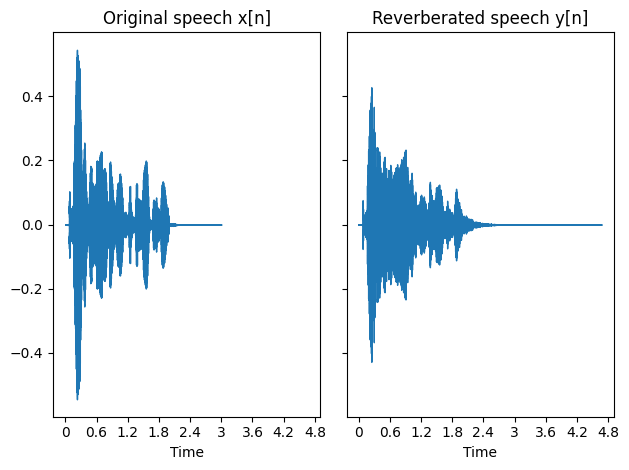

In [ ]:
# ***********************************************************************************************
# 2. Calculate the convolution between the clean speech signal and the RIR

# Convolution
y = np.convolve(x, rir)

# ***********************************************************************************************
# 3. Plot waveform of original speech and reverberated speech side by side
# Normalize audio
gamma = np.sqrt((N*rms_x**2)/(np.sum(y**2)))
print(f'Scaling factor :{gamma:.4f}')
y_norm = gamma * y

# Plot
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
librosa.display.waveshow(x, sr=sampling_rate, ax=axs[0])
axs[0].set_title('Original speech x[n]')
librosa.display.waveshow(y_norm, sr=sampling_rate, ax=axs[1])
axs[1].set_title('Reverberated speech y[n]')
plt.tight_layout()

# Player
ipd.display(ipd.Audio(x, rate=sampling_rate))
ipd.display(ipd.Audio(y_norm, rate=sampling_rate))

The principle of the impulse response is used to simulate other devices that transform an input signal. For example, we could use the impulse response to simulate a speaker or a vinyl disc. Once the impulse response of these devices is available, the same convolution-based approach that we have seen above can be used.

# **Live Coding**: Background Noise
Background noise can be added to a clean signal to simulate the presence of external sound sources that can affect the quality of a video call (e.g. traffic, keyboard typing, competing speaker).


## Problem Definition
To adjust how strong is the noise in the corrupted signal we use the concept of signal-to-noise ratio (SNR):

- $ \mathrm{SNR} = \frac{P_{signal}}{P_{noise}} $

- $ \mathrm{SNR_{dB}} = 10 \log _{{10}} \mathrm {SNR} $.

The SNR is the ratio between speech and noise power, it is typically expressed in dB instead of linear scale. The average power of a signal can be measured with the root mean squared (RMS) of the signal calculated as: $ P_x = \sqrt{\frac{1}{N}(x{^2_1} + x{^2_2} + ... + x{^2_n})} $ where $N$ is the length of the signal $x$

Simulating noisy speech consists of summing a scaled noise signal with the speech signal. To scale the noise signal we need to calculate the desired noise power which depends on the SNR value that we choose.

- 1) Choose an SNR value in dB: $\mathrm{SNR_{dB}}$
- 2) Convert the SNR value from dB to linear: $\mathrm{SNR}=10^{\frac{\mathrm{SNR_{dB}}}{10}}$
- 3) Calculate the desired noise power: $\widehat{P}_{noise}=\frac{P_{signal}}{\mathrm{SNR}}$
- 4) Scale the noise using the desired noise power: $\hat{s}[n] = s[n] * \frac{\widehat{P}_{noise}}{P_{noise}}$
 - $s[n]$ is the original noise signal
 - $\hat{s}[n]$ is the scaled noise signal
 - $P_{noise}$ is the original noise power (RMS)
 - $\widehat{P}_{noise}$ is the desired noise power (RMS)
 - The ratio $\alpha=\frac{\widehat{P}_{noise}}{P_{noise}}$ is the scaling factor.
    - $\alpha=1$ when $P_{noise}=\widehat{P}_{noise}$ which is true when we chose an SNR that is equal to the original SNR
    - If we increase the SNR, the desired power $\widehat{P}_{noise}$ is lower than the original noise power
    - So, the scaling factor is relative to the original SNR
- 5) Sum the two signals: $y[n] = x[n] + \alpha*s[n]$


## Coding Part ##
1. Add applause noise to a clean speech signal using SNR of 5 dB
2. Plot waveform and spectrogram of the noise signal
3. Plot waveform of speech and noisy signal side by side

alpha=0.2212238550925831


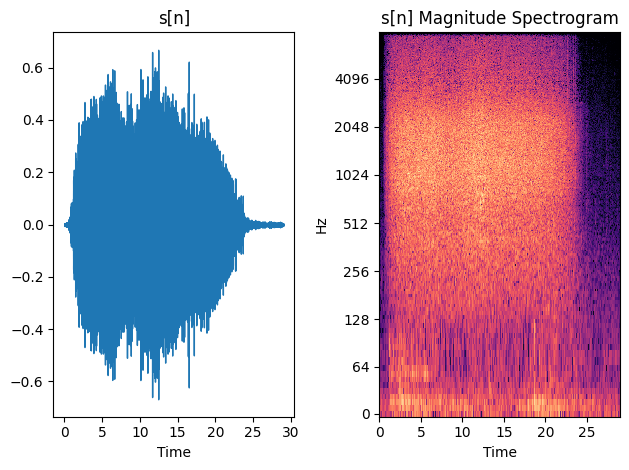

In [ ]:
# Note: Speech and background signals must have the same length in order to be summed together. This is never the case.
# If the background signal is shorter, we repeat it until reaching the length of the speech signal.
# If the speech signal is shorter, we just truncate the background signal to the length of the speech signal.

# ***********************************************************************************************
# 1. Add noise to a clean speech signal using SNR of 5 dB
def add_noise(x, s, snr_db):

  # First let's match the length of the two signals
  x_len = x.shape[0]
  s_len = s.shape[0]

  if x_len > s_len:
    # Calculate how many times we need to repeat the signal and round up to the nearest integer
    reps = math.ceil(x_len/s_len)

    # Use the function np.tile to repeat an array
    s = np.tile(s, reps)

  # Truncate the background signal
  s = s[:x_len]

  # Check if the lengths are the same
  assert x_len == s.shape[0]

  # Convert SNRdb to linear
  snr = 10**(snr_db/10)

  # Estimate noise and signal power
  sp = np.sqrt(np.mean(s**2))
  xp = np.sqrt(np.mean(x**2))

  # Calculate desired noise power based on the SNR value
  sp_target = xp/snr

  # Scale factor noise signal
  alpha = sp_target/sp
  print(f'alpha={alpha}')

  # Sum speech and background noise
  y = x + alpha*s
  return y

# Load noise
noise_filename = 'applause.wav'
s, _ = librosa.load(noise_filename, sr=sampling_rate, mono=True)

# Mix speech and noise at 5 dB
snr_db = 5
y = add_noise(x, s, snr_db)

# ***********************************************************************************************
# 2. Plot waveform and spectrogram of the noise signal
fig, axs = plt.subplots(nrows=1, ncols=2)
librosa.display.waveshow(s, sr=sampling_rate, ax=axs[0])
axs[0].set_title('s[n]')
librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(s)), ref=np.max), sr=sampling_rate, ax=axs[1], y_axis='log', x_axis='time')
axs[1].set_title('s[n] Magnitude Spectrogram')
plt.tight_layout()

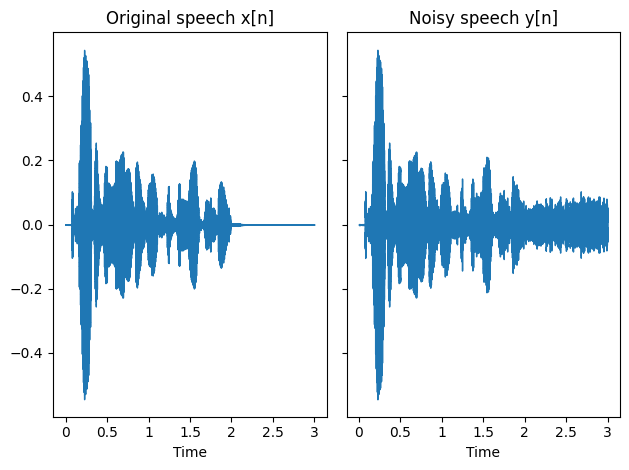

In [ ]:
# ***********************************************************************************************
# 3. Plot waveform of speech and noisy signal side by side
fig2, axs2 = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
librosa.display.waveshow(x, sr=sampling_rate, ax=axs2[0])
axs2[0].set_title('Original speech x[n]')
librosa.display.waveshow(y, sr=sampling_rate, ax=axs2[1])
axs2[1].set_title('Noisy speech y[n]')
plt.tight_layout()

# Player
ipd.display(ipd.Audio(x, rate=sampling_rate, normalize=False))
ipd.display(ipd.Audio(y, rate=sampling_rate, normalize=False))

# **Student Activity**: Voice Call Simulation
Simulating real-world recordings can be done by combining multiple degradations together. In this section we combine the three degradations that we have seen above: clipping, room impulse response, and background noise.

When combining degradations together, it is important to decide in which order we modify the clean speech signal. For example, when someone speaks on the phone in a crowded space and clipping occurs, the background noise could also be affected by clipping. If we clip the clean signal before adding background noise, we will not simulate this effect.

## Exercise
1. Simulate a phone recording in a crowded art gallery with 5 dB SNR and $2\%$ of the samples corrupted by digital clipping.

To simulate a voice call we should use the following degradation order:
1) RIR, 2) Background Noise, 3) Clipping.

Why not convolving the background noise with RIR?
Because we assume that the background noise has been recorded in the same space, so it is already affected by the environment.

alpha=0.31995519807581846
Scaling factor :0.5815


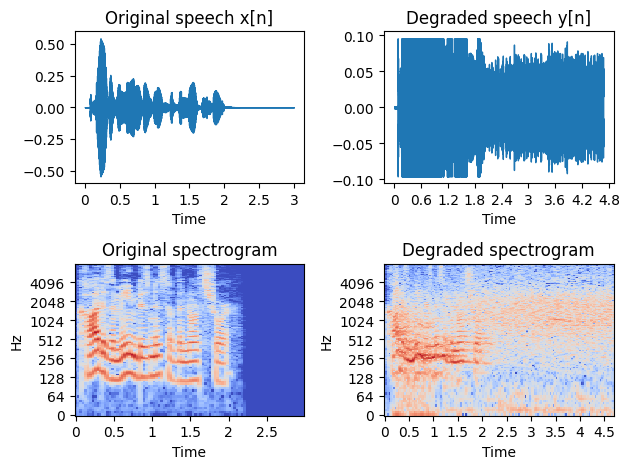

In [ ]:
# ***********************************************************************************************

# We already loaded the audio files above
# x   - clean signal
# rir - room impulse response signal
# s   - background noise signal

# Parameter settings
snr_db = 5
clip_factor = 2

# Apply impulse response
y = np.convolve(x, rir)

# Add background noise at 5 dB
y = add_noise(y, s, snr_db)

# Clip 5% of the samples
# Get percentile values
lower_percentile, higher_percentile, percentile_values = get_percentile(clip_factor)
y = clip_signal(y, percentile_values)

# Normalize
gamma = np.sqrt((N*rms_x**2)/(np.sum(y**2)))
print(f'Scaling factor :{gamma:.4f}')
y_norm = gamma*y

# Plot clean vs degraded signal (time domain and spectrogram)
fig3, axs3 = plt.subplots(nrows=2, ncols=2, sharex=False, sharey=False)
librosa.display.waveshow(x, sr=sampling_rate, ax=axs3[0,0])
axs3[0,0].set_title('Original speech x[n]')
librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(x))), sr=sampling_rate, ax=axs3[1,0], x_axis='time', y_axis='log')
axs3[1,0].set_title('Original spectrogram')
librosa.display.waveshow(y_norm, sr=sampling_rate, ax=axs3[0,1])
axs3[0,1].set_title('Degraded speech y[n]')
librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(y_norm))), sr=sampling_rate, ax=axs3[1,1], x_axis='time', y_axis='log')
axs3[1,1].set_title('Degraded spectrogram')
plt.tight_layout()

# Player
ipd.display(ipd.Audio(x, rate=sampling_rate, normalize=False))
ipd.display(ipd.Audio(y_norm, rate=sampling_rate, normalize=False))


N.B: A phone recording exhibits more degradations in a real-world setting. We haven't considered the codec used to compress audio, the impulse response of the phone mic, and the impulse response of the receiver phone speaker.

# **Assignment**

### **Part 1 [5pt]**
1. Given these 3 plots (a,b,c). Indicate which plot is unclipped, clipped, or clipped + normalized and explain why [2pt]


(a)


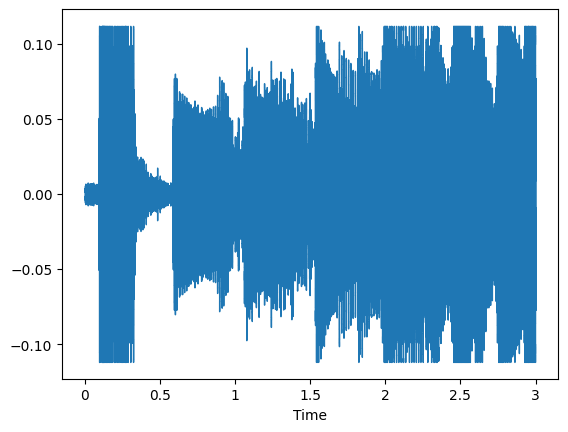

(b)


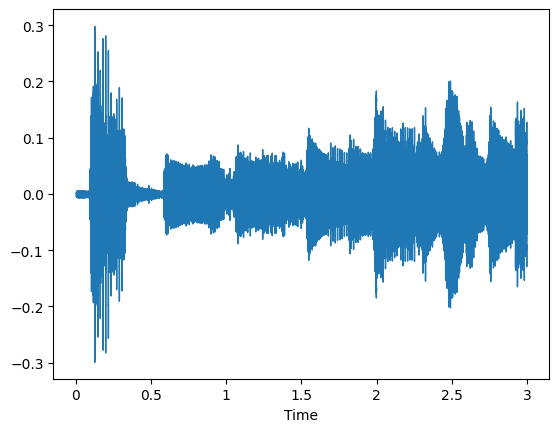

(c)


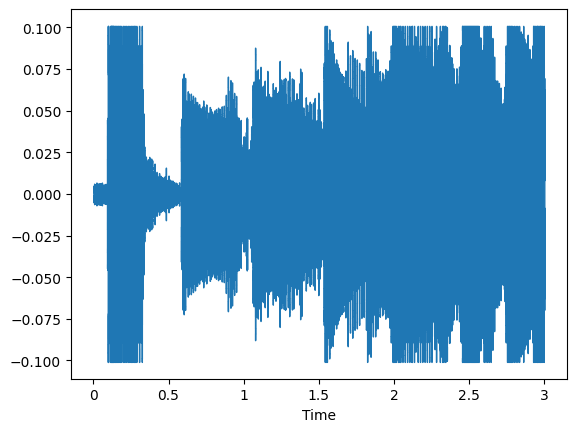

In [ ]:
print('(a)')
ipd.display(Image('CLIP_image_1.png'))
print('(b)')
ipd.display(Image('CLIP_image_2.png'))
print('(c)')
ipd.display(Image('CLIP_image_3.png'))

a)
Based on the plot image you provided, there are clear indications of clipping, which is evident from the flat sections at the extremes of the data. These flat sections suggest that the data has exceeded a certain threshold and has been cut off at that value. However, without numerical axes values, it's difficult to say for certain if it has also been normalized. Normalization is indicated by the data being scaled to a particular range, and typically we would expect to see the y-axis labeled with that range if it were normalized (e.g., -1 to 1)

Given these details, we can most confidently state that the plot shows clipping due to the flat horizontal lines indicating that a maximum threshold has been reached and the data has been truncated at these points. Whether or not it has been normalized would depend on the actual range of the data which cannot be determined without additional information.

b)
The second graphical representation presents a temporal sequence of data points, ostensibly capturing the dynamic variations of a dataset over a specified interval. Notably, the plot lacks the characteristic plateaus typically indicative of the thresholding effects inherent in clipped signals, suggesting the full integrity of the dataset is maintained. Thus, one can infer that the visualized data has not been subjected to amplitude limiting or saturation.
Furthermore, the depicted signal demonstrates oscillatory behavior within an approximate amplitude range of -0.3 to 0.3. The absence of conventional normalization markers, such as a bounded range of -1 to 1 or 0 to 1, does not conclusively imply the data is non-normalized due to the lack of contextual baselines. Normalization, in computational contexts, often involves scaling the data to fit within a predetermined scope, facilitating comparative analysis or ensuring consistency with algorithmic input requirements. However, normalization processes vary and are contingent upon the specific objectives and standards of the analysis at hand.
Consequently, with the given visualization, one could provisionally categorize the signal as unclipped, with the caveat that definitive statements regarding normalization cannot be established sans additional data or metadata delineating the preprocessing protocols applied to the dataset prior to its graphical instantiation. The analytical rigor in such interpretations is foundational in computational disciplines, necessitating precise delineation of data transformations to support the validity of subsequent interpretations or computational operations.



c)
Upon examining the provided plot, which represents a temporal sequence of data points, several features stand out indicating specific signal processing considerations. Most notably, the initial segment of the graph exhibits a plateau, both at the peak and trough, suggestive of a clipping effect. Clipping occurs when the signal amplitude exceeds the system's maximum or minimum capability for recording or reproduction, resulting in a flattening of the waveform at those extremes.

Conversely, the rest of the data does not display such flat extremes and continues to show variability throughout the range, thus giving no indication of further clipping. The absence of a symmetric constraint on the amplitude, such as would be seen in a normalized signal bound between -1 and 1 or 0 to 1, indicates that the signal has not been normalized to a standard range.

The amplitude of the signal fluctuates within approximately -0.1 to 0.1, but without knowledge of the original amplitude range of the signal before any potential processing, it is not feasible to ascertain the presence of normalization post-clipping. It is conceivable that some transformation has been applied to the data, but the plot alone is not sufficiently informative to confirm this.

When discussing such graphs within the realm of computer science, particularly in signal processing, it is important to consider that signal clipping can result in distortion, which may affect further analysis or processing, such as feature extraction or filtering. Consequently, this characteristic of the signal should be accounted for when designing or applying algorithms for analysis or when interpreting the data.

The provided plot, therefore, offers a visual cue of clipping at the initial stage but lacks clear evidence of normalization.

2.  In artificial reverberation, which specific problem does the impulse response solve? Use max 300 characters. [3pt]

In artificial reverberation, the impulse response characterizes how an environment responds to a pure, momentary sound, allowing the recreation of that space's acoustics digitally.

### **Part 2 [10pt]**

Design a system that simulates a live recording of a clean guitar sample (guitar_sample.flac) in a concert hall (concert_hall.wav)
with audience applause (applause.wav) mixed at 15 dB SNR. Due to some issues with the recording equipment,
0.001% of the audio samples are corrupted by clipping.

  1. Indicate the order of the degradations and explain why this is your choice [5 pt]

  2. Generate the degraded file by using the functions created during the lab and add players to hear both clean and degraded signals. The two signals must be easy to play and to compare [5 pt]




1)

first one)
Convolution with the concert hall impulse response: This step simulates the natural reverberation effect as the clean guitar signal interacts with the acoustics of the concert hall. This is the first step because it mimics the primary environmental impact on the sound as it occurs.


second one)
Mixing with audience applause at 15 dB SNR: Following the convolution, the audience noise (applause) is mixed in. This simulates the background noise present during the performance. The SNR level sets how prominent this noise is in relation to the guitar signal. The order here is crucial because the audience noise should also be subjected to the same reverberation effects as the

third one)
Introduction of clipping to the signal: Clipping is added last because it represents a limitation of the recording equipment, affecting all aspects of the recording equally—both the direct guitar signal, its reverberation, and the audience noise. Since clipping is a form of distortion that can happen when the recording device is unable to handle the amplitude of all incoming sounds, it's applied to the signal after all the environmental and performance-related sounds have been combined.

This sequence is chosen to closely simulate the process and order in which sound is transformed during a live performance recording in a concert hall with an audience.





#2

In [ ]:
import numpy as np
import soundfile as sf

# Helper function to convert stereo audio to mono
def stereo_to_mono(audio):
    return np.mean(audio, axis=1) if audio.ndim > 1 else audio

# Function to apply convolution with an impulse response (reverberation)
def convolve_signal(signal, ir):
    return np.convolve(signal, ir, mode='full')

# Function to add noise to a signal at a specified SNR
def add_noise(signal, noise, snr_db):
    noise = np.resize(noise, signal.shape)  # Ensure noise is the same length as the signal
    signal_power = np.mean(signal ** 2)
    noise_power = np.mean(noise ** 2)
    scaling_factor = np.sqrt(signal_power / (noise_power * (10 ** (snr_db / 10))))
    return signal + noise * scaling_factor

# Function to apply clipping to a small percentage of the signal
def clip_signal(signal, clip_percentage):
    num_samples = int(clip_percentage * len(signal))
    clip_indices = np.random.choice(len(signal), num_samples, replace=False)
    signal[clip_indices] = np.clip(signal[clip_indices], -1, 1)  # Clipping
    return signal

# Loading the files (ensure that the paths match the files you have)
guitar_sample, guitar_fs = sf.read('guitar_sample.flac')
concert_hall_ir, concert_hall_fs = sf.read('concert_hall.wav')
applause, applause_fs = sf.read('applause.wav')

# Convert all audio to mono if they are not already
guitar_sample_mono = stereo_to_mono(guitar_sample)
concert_hall_ir_mono = stereo_to_mono(concert_hall_ir)
applause_mono = stereo_to_mono(applause)

# Apply convolution to simulate reverberation
guitar_in_hall = convolve_signal(guitar_sample_mono, concert_hall_ir_mono)

# Add applause noise at 15 dB SNR
guitar_with_applause = add_noise(guitar_in_hall, applause_mono, 15)

# Apply clipping to 0.001% of the samples
final_degraded_signal = clip_signal(guitar_with_applause, 0.00001)

# Save the final degraded signal
sf.write('degraded_guitar_in_concert_hall.wav', final_degraded_signal, guitar_fs)



# ***Additional Material***
Useful links if you are interested in exploring this topic.

*   Freesound https://freesound.org/
  * Find impulse responses, background noise signals, general sounds
*   Echothief http://www.echothief.com/downloads/
  * Impulse responses professionally recorded. Over a hundred unique spaces from around North America: caves, skateparks, stairwells, underpasses, glaciers, fortresses, and more.
* Clean speech datasets https://github.com/jim-schwoebel/voice_datasets
* PyTorch audio augmentations (deep learning) https://github.com/iver56/audiomentations
* Pedalboard https://spotify.github.io/pedalboard/
  * Useful if you want to manipulate clean audio with audio plugins via python. Several effects used in music productions




